# Biases in regression outputs
The goal of this notebook is to show that when the data have small information about the label, then population-level inferences using the output labels are biased.

## Author:
- **David W Hogg** (NYU) (MPIA) (Flatiron)

## License:
Copyright 2023, 2024 the author. All code is released open-source under the MIT License.

## To-do:
- Make plots that are publication-worthy.
- Play with hyper-parameters of the MLP and the data generation to see how the results depend on choices.

In [1]:
import numpy as np
import pylab as plt
from matplotlib import rcParams
from sklearn.neural_network import MLPRegressor
from scipy import special

In [2]:
# set hyper-parameters
M = 110 # dimension of the data (thinking XP spectra)
K = 14 # number of latent (unknown) parameters beyond age and guiding radius
N_train = 2 ** 12
N_valid = 2 ** 11
N_extra = 2 ** 17
N_total = N_train + N_valid + N_extra
maxR = 14.0 # kpc
maxage = 14.0 # Gyr
agerange = 2.0 # Gyr
agefactor = 0.1 # make this smaller to reduce age information in the data set
datanoise = 0.05 # noise level for the data
agenoise = 1.0 # Gyr age label noise level
print(N_train, N_valid, N_total, maxR)

4096 2048 137216 14.0


In [3]:
# make derivatives of data wrt age and latents; MAKE THESE FIRST
rng = np.random.default_rng(17)
age_vec = agefactor * rng.normal(size=M)
latent_vecs = rng.normal(size=(K, M))

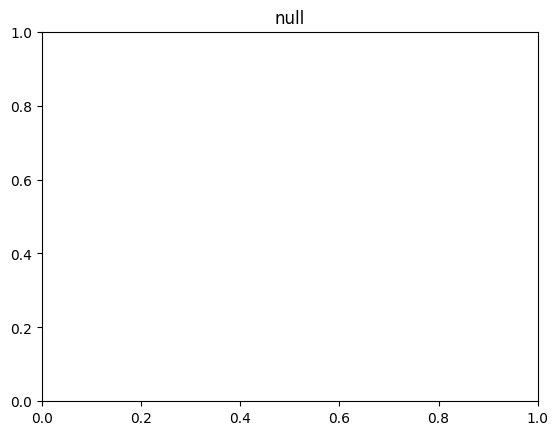

In [4]:
plt.title("null") # this seems to be required for the next line to have an effect?
rcParams["figure.figsize"] = (4, 4)

In [5]:
# make latent true ages and other properties
true_guide_radii = rng.uniform(0., maxR, size=N_total)
true_ages = maxage - (maxage / maxR) * true_guide_radii + agerange * rng.normal(size=N_total)
okay = (true_ages > 0.) * (true_ages < maxage)
true_guide_radii = true_guide_radii[okay]
true_ages = true_ages[okay]
N_total = len(true_ages)
N_test = N_total - N_train - N_valid
true_latents = rng.normal(size=(N_total, K))
print(true_guide_radii.shape, true_ages.shape, true_latents.shape)

(121517,) (121517,) (121517, 14)


In [6]:
# make true data
true_data = (true_ages[:, None] * age_vec[None, :]
            + true_latents @ latent_vecs) / np.sqrt(K)
true_data = np.clip(true_data + 1, 0.0, 1.0) # apply RELU-like nonlinearity
print(true_data.shape)

(121517, 110)


In [7]:
# add noise to the data and labels
data = true_data + datanoise * rng.normal(size=true_data.shape)
ages = true_ages + agenoise * rng.normal(size=true_ages.shape)
print(data.shape, ages.shape)

(121517, 110) (121517,)


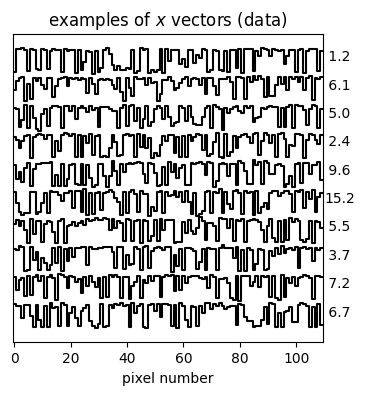

In [8]:
plt.title("examples of $x$ vectors (data)")
for i in range(10):
    offset = 1.3 * i
    plt.step(data[i] + offset, "k-", where="mid")
    plt.text(M, offset + 0.5, "{:4.1f}".format(ages[i]))
plt.xlim(-0.5, M - 0.5)
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("pixel number")
plt.savefig("data_examples.png", dpi=150)

In [9]:
# Make function to take means in bins of data
def means_in_bins(xs, ys):
    nbin = 14
    meanx = np.zeros(nbin)
    meany = np.zeros(nbin)
    stdy = np.zeros(nbin)
    for xmin in range(nbin):
        I = (xs > xmin) * (xs < (xmin + 1.))
        meanx[xmin] = np.mean(xs[I])
        meany[xmin] = np.mean(ys[I])
        stdy[xmin] = np.std(ys[I]) / np.sqrt(np.sum(I))
    return meanx, meany, stdy

Text(0, 0.5, 'true label $y$ (measured age)')

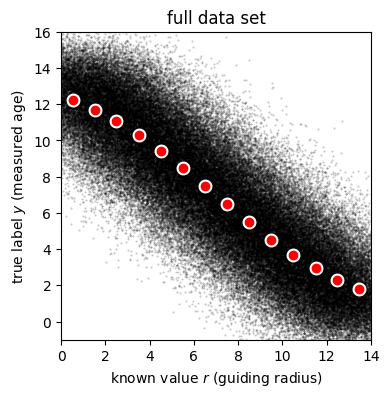

In [10]:
plt.title("full data set")
mean_radii, mean_ages, std_ages = means_in_bins(true_guide_radii, ages)
plt.scatter(true_guide_radii, ages, s=0.2, c="k", alpha=0.25)
plt.plot(mean_radii, mean_ages, "wo", mew=4)
plt.plot(mean_radii, mean_ages, "ro")
radiuslim = (0., 14.)
plt.xlim(radiuslim)
agelim = (-1., 16.)
plt.ylim(agelim)
plt.xlabel("known value $r$ (guiding radius)")
plt.ylabel("true label $y$ (measured age)")

In [11]:
# Set up train, validate, and test sets
X_train = data[:N_train]
Y_train = ages[:N_train]
radii_train = true_guide_radii[:N_train]
X_valid = data[N_train:N_train + N_valid]
Y_valid = ages[N_train:N_train + N_valid]
radii_valid = true_guide_radii[N_train:N_train + N_valid]
X_test = data[N_train + N_valid:]
Y_test = ages[N_train + N_valid:]
radii_test = true_guide_radii[N_train + N_valid:]
print(X_train.shape, X_valid.shape, X_test.shape)

(4096, 110) (2048, 110) (115373, 110)


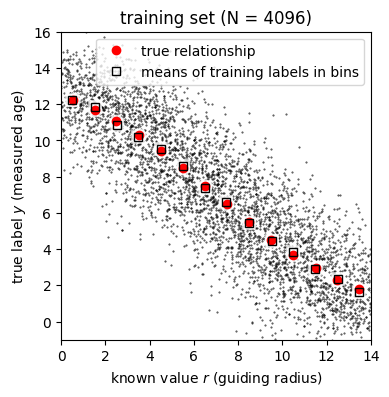

In [12]:
plt.title("training set (N = {:d})".format(N_train))
mean_train_radii, mean_train_ages, std_train_ages = means_in_bins(radii_train, Y_train)
plt.scatter(radii_train, Y_train, s=0.2, c="k", alpha=0.8)
shadow_alpha=0.8
plt.plot(mean_radii, mean_ages, "wo", mew=4, alpha=shadow_alpha)
plt.plot(mean_train_radii, mean_train_ages, "ws", mfc="none", mew=4, alpha=shadow_alpha)
plt.plot(mean_radii, mean_ages, "ro", label="true relationship")
plt.plot(mean_train_radii, mean_train_ages, "ks", mfc="none", label="means of training labels in bins")
plt.xlim(radiuslim)
plt.ylim(agelim)
plt.legend()
plt.xlabel("known value $r$ (guiding radius)")
plt.ylabel("true label $y$ (measured age)")
plt.savefig("training_data.png", dpi=150)

In [13]:
# set up a MLP to solve this problem
MLP_kwargs = {'hidden_layer_sizes': (64, 32, 16),
              'activation': 'relu',
              'solver': 'adam',
              'alpha': 0.0001,
              'batch_size': 'auto',
              'learning_rate': 'constant',
              'learning_rate_init': 0.001,
              'power_t': 0.5,
              'max_iter': 1000,
              'shuffle': True,
              'random_state': None,
              'tol': 0.0001,
              'verbose': True,
              'warm_start': False,
              'momentum': 0.9,
              'nesterovs_momentum': True,
              'early_stopping': False,
              'validation_fraction': 0.1,
              'beta_1': 0.9,
              'beta_2': 0.999,
              'epsilon': 1e-08,
              'n_iter_no_change': 10,
              'max_fun': 15000}
mlp = MLPRegressor(**MLP_kwargs)

In [14]:
# perform regression
regr = mlp.fit(X_train, Y_train)
print(regr)

Iteration 1, loss = 24.80742008
Iteration 2, loss = 8.78946027
Iteration 3, loss = 7.65143770
Iteration 4, loss = 7.39606327
Iteration 5, loss = 7.14166288
Iteration 6, loss = 6.81415189
Iteration 7, loss = 6.25813920
Iteration 8, loss = 5.43862209
Iteration 9, loss = 4.36277510
Iteration 10, loss = 3.31014159
Iteration 11, loss = 2.66169530
Iteration 12, loss = 2.53774525
Iteration 13, loss = 2.46331979
Iteration 14, loss = 2.38569569
Iteration 15, loss = 2.31906352
Iteration 16, loss = 2.27529857
Iteration 17, loss = 2.25394454
Iteration 18, loss = 2.17379093
Iteration 19, loss = 2.16781216
Iteration 20, loss = 2.10211068
Iteration 21, loss = 2.06337410
Iteration 22, loss = 2.02867808
Iteration 23, loss = 1.98944423
Iteration 24, loss = 1.98069611
Iteration 25, loss = 1.93791770
Iteration 26, loss = 1.92093731
Iteration 27, loss = 1.90271751
Iteration 28, loss = 1.90145993
Iteration 29, loss = 1.86009788
Iteration 30, loss = 1.84960040
Iteration 31, loss = 1.81822663
Iteration 32, lo

In [15]:
# Check that the regression is okay
Y_valid_hat = regr.predict(X_valid)
print(Y_valid, Y_valid - Y_valid_hat)
print("bias:", np.mean(Y_valid - Y_valid_hat))
rms = np.sqrt(np.mean((Y_valid - Y_valid_hat) ** 2))
print("rms:", rms)

[2.79598008 2.70846587 5.34281368 ... 2.32082975 8.43730644 5.26543604] [ 0.05457626 -4.76348373 -0.64120822 ... -0.04740474 -1.93519505
  0.24641936]
bias: 0.006769702797394892
rms: 2.4166342483565946


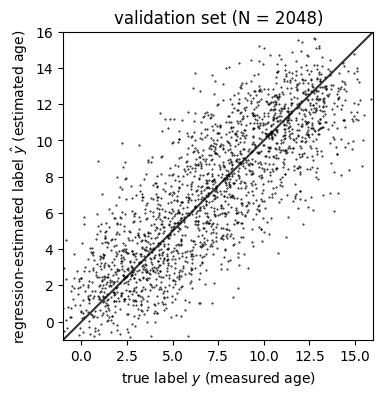

In [16]:
plt.title("validation set (N = {:d})".format(N_valid))
plt.scatter(Y_valid, Y_valid_hat, s=0.2, c="k")
foo = plt.ylim()
plt.plot(foo, foo, "k-", alpha=0.8, zorder=-10)
plt.ylim(agelim)
plt.xlim(agelim)
plt.xlabel("true label $y$ (measured age)")
plt.ylabel("regression-estimated label $\hat{y}$ (estimated age)")
plt.savefig("validation.png", dpi=150)

In [17]:
# run on the test set
Y_test_hat = regr.predict(X_test)
print(Y_test_hat.shape)

(115373,)


(115373,) (115373,)
[' 32.2', ' 26.3', ' 21.1', ' 11.5', '  7.2', '  3.0', '  1.6', '  3.4', '  6.0', '  8.3', ' 11.5', ' 16.7', ' 21.8', ' 23.4']


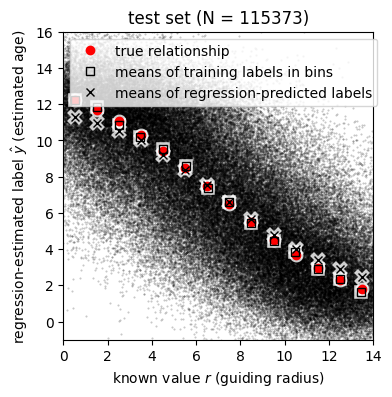

In [18]:
plt.title("test set (N = {:d})".format(N_test))
print(radii_test.shape, Y_test_hat.shape)
mean_regr_radii, mean_regr_ages, std_regr_ages = means_in_bins(radii_test, Y_test_hat)
nsigma = [" {:4.1f}".format(ns) for ns in np.abs(mean_regr_ages - mean_ages) / std_regr_ages]
print(nsigma)
plt.scatter(radii_test, Y_test_hat, s=0.2, c="k", alpha=0.25)
shadow_alpha=0.8
plt.plot(mean_radii, mean_ages, "wo", mew=4, alpha=shadow_alpha)
plt.plot(mean_train_radii, mean_train_ages, "ws", mfc="none", mew=4, alpha=shadow_alpha)
plt.plot(mean_regr_radii, mean_regr_ages, "wx", mfc="none", mew=4, ms=8, alpha=shadow_alpha)
plt.plot(mean_radii, mean_ages, "ro", label="true relationship")
plt.plot(mean_train_radii, mean_train_ages, "ks", mfc="none", label="means of training labels in bins")
plt.plot(mean_regr_radii, mean_regr_ages, "kx", mfc="none", label="means of regression-predicted labels")
plt.xlim(radiuslim)
plt.ylim(agelim)
plt.legend()
plt.xlabel("known value $r$ (guiding radius)")
plt.ylabel("regression-estimated label $\hat{y}$ (estimated age)")
plt.savefig("test_data_results.png", dpi=150)

## Treating the outputs as posteriors.

Let's see if we can fix this behavior by treating the outputs of our regression as posteriors. First we need a function that expresses our prior. The prior is a little weird, but workable. It's a convolution of a uniform distribution with a Gaussian, with cuts placed on the lower and upper bounds of 0.0 and 16.0. The convolution of the uniform distribution with our gaussian gives us a distribution of the form:
$$p(y) = \frac{1}{(r_\mathrm{max}-r_\mathrm{min})\sqrt{2 \sigma^2 \pi}} \int_{r_\mathrm{min}}^{r_\mathrm{max}} \exp \left( -\frac{(x - y)^2}{2 \sigma^2}\right) dx$$
We're only going to need this for relative weights, so we can ignore the re-normalization we need to do for the second cut of $y_\mathrm{min}$ and $y_\mathrm{max}$. Here $\sigma$ is the `agerange` scatter added to the relationship between radii and age.

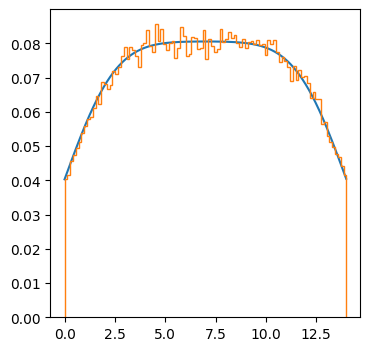

In [19]:
# Let's implement the prior described above.
def prior_ys(ys):
    norm = 1 / (maxR * agerange * np.sqrt(2 * np.pi))
    exp_const = 1 / (2 * agerange ** 2)
    integral = 0.5 * (special.erf((maxR - ys) * np.sqrt(exp_const)) - special.erf(-ys * np.sqrt(exp_const)))
    integral *= np.sqrt(np.pi / exp_const)
    return integral * norm

# Check that the prior matches that histogram of true age values. Note that we need to normalize by the sum
# since we haven't added the normalization from the cuts at 0.0 and maxage.
dy = 0.01
y_plot = np.arange(0.0, maxage, dy)
plt.plot(y_plot, prior_ys(y_plot) / np.sum(prior_ys(y_plot) * dy))
plt.hist(true_ages, density=True, bins=100, histtype='step')
plt.show()

Next, let's consider the variational posterior implicit in our optimization. We can think of the MSE loss as optimizing the mean of a variational posterior with some fixed $\sigma_\mathrm{post}$. Since we didn't optimize $\sigma_\mathrm{post}$, we will use the estimate from the training set of $\sigma_\mathrm{post}$. Let's sample from this Gaussian.

In [24]:
n_samples = 10
Y_test_hat_samples = rng.normal(size=(Y_test_hat.shape[0], n_samples)) * rms + Y_test_hat[:, np.newaxis]

Now we want to divide out the prior and re-calculate the mean (such that combining multiple estimates won't multiply the prior). There's one tricky choice here: our prior has no weight outside the range [0,`maxage`], but the posterior we're predicting does not have hard boundaries. In fact, it's impossible for our Gaussian posterior to correctly reflect the prior. If we divide by the prior, this would lead to infinite weight for any sample that falls outside the prior range. There are three options for how we can approach this:

1. Assign artificially large prior weight outside the boundary, thereby making the weight of 1/prior in the final sample artifically very small. This is equivalent to throwing out samples from the posterior that fall outside the prior boundary. Note that because we are predicting Gaussians, this will bias our samples further from the edges of the prior, compounding the problem.
2. Assume that the prior equation we wrote above extends beyond the boundaries of [0,`maxage`].
3. Assume that the prior is flat outside the boundaries of [0,`maxage`] (i.e. $p(y<0) = p(0)$ and $p(y>\max_\mathrm{age}) = p(\max_\mathrm{age})$.

These are three 'reasonable' choices, but there are many more choices one could make. The fundamental issue is that we know our model _cannot_ be expressing the true prior, since the funcitonal form we have provided does not allow that. But hopefully we'll see that choices 2 and 3 help alleviate the bias we saw in the previous plot.

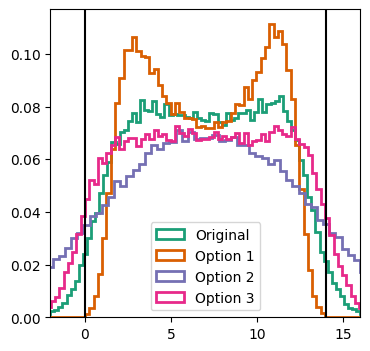

In [33]:
# Sample weights for option 1
sample_weights_cut = 1 / prior_ys(Y_test_hat_samples)
sample_weights_cut[Y_test_hat_samples < 0.0] = 1 / 1e10
sample_weights_cut[Y_test_hat_samples > maxage] = 1 / 1e10
sample_weights_cut /= np.sum(sample_weights_cut, axis=-1, keepdims=True)

# Sample weights for option 2
sample_weight_continue = 1 / prior_ys(Y_test_hat_samples)
sample_weight_continue /= np.sum(sample_weight_continue, axis=-1, keepdims=True)

# Sample weights for option 3
sample_weight_flat = 1 / prior_ys(Y_test_hat_samples)
sample_weight_flat[Y_test_hat_samples < 0.0] =  1 / prior_ys(0.0)
sample_weight_flat[Y_test_hat_samples > maxage] =  1 / prior_ys(maxage)
sample_weight_flat /= np.sum(sample_weight_flat, axis=-1, keepdims=True)

Y_test_cut = np.average(Y_test_hat_samples, weights=sample_weights_cut, axis=-1)
Y_test_continue = np.average(Y_test_hat_samples, weights=sample_weight_continue, axis=-1)
Y_test_flat = np.average(Y_test_hat_samples, weights=sample_weight_flat, axis=-1)

colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
plt.hist(Y_test_hat, density=True, bins=100, histtype='step', color=colors[0], lw=2, label='Original')
plt.hist(Y_test_cut, density=True, bins=100, histtype='step', color=colors[1], lw=2, label='Option 1')
plt.hist(Y_test_continue, density=True, bins=100, histtype='step', color=colors[2], lw=2, label='Option 2')
plt.hist(Y_test_flat, density=True, bins=100, histtype='step', color=colors[3], lw=2, label='Option 3')
plt.xlim([-2, 16])
plt.legend()
        
plt.axvline(14, c='k')
plt.axvline(0, c='k')
plt.show()

If we were correctly dividing by the prior being expressed by the model the distribution would be unfirom. We know the model cannot have be expressing the true prior, so it's not surprising that Option 1 seems like the worst choice. Of the three we've tried, Option 3 gets closest to reconstructing the effective prior learned by our model. Let's plug it into the regression test performed earlier and see if it improves it.

(115373,) (115373,)
[' 16.0', ' 11.0', '  6.1', '  0.2', '  0.2', '  1.5', '  2.7', '  1.6', '  1.2', '  0.4', '  0.7', '  3.6', '  7.2', '  8.3']


Text(0, 0.5, 'regression-estimated label $\\hat{y}$ (estimated age)')

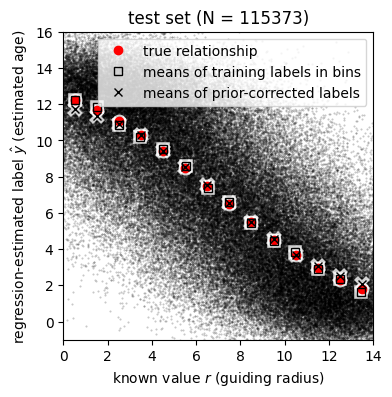

In [51]:
plt.title("test set (N = {:d})".format(N_test))
print(radii_test.shape, Y_test_hat.shape)
mean_regr_radii, mean_regr_ages, std_regr_ages = means_in_bins(radii_test, Y_test_flat)
nsigma = [" {:4.1f}".format(ns) for ns in np.abs(mean_regr_ages - mean_ages) / std_regr_ages]
print(nsigma)
plt.scatter(radii_test, Y_test_resampled, s=0.2, c="k", alpha=0.25)
shadow_alpha=0.8
plt.plot(mean_radii, mean_ages, "wo", mew=4, alpha=shadow_alpha)
plt.plot(mean_train_radii, mean_train_ages, "ws", mfc="none", mew=4, alpha=shadow_alpha)
plt.plot(mean_regr_radii, mean_regr_ages, "wx", mfc="none", mew=4, ms=8, alpha=shadow_alpha)
plt.plot(mean_radii, mean_ages, "ro", label="true relationship")
plt.plot(mean_train_radii, mean_train_ages, "ks", mfc="none", label="means of training labels in bins")
plt.plot(mean_regr_radii, mean_regr_ages, "kx", mfc="none", label="means of prior-corrected labels")
plt.xlim(radiuslim)
plt.ylim(agelim)
plt.legend()
plt.xlabel("known value $r$ (guiding radius)")
plt.ylabel("regression-estimated label $\hat{y}$ (estimated age)")

The population-level predictions are much better, with the largest errors showing up at the edges where the tension between the true training prior and what the variational distribution can express is most extreme. Let's also quick check how this resampling has affected our errors:

In [38]:
# Check that the regression is okay
print("bias:", np.mean(Y_test - Y_test_flat))
rms = np.sqrt(np.mean((Y_test - Y_test_flat) ** 2))
print("rms:", rms)

bias: 0.002075530503678048
rms: 2.6904318249913635


Text(0, 0.5, 'regression-estimated label $\\hat{y}$ (estimated age)')

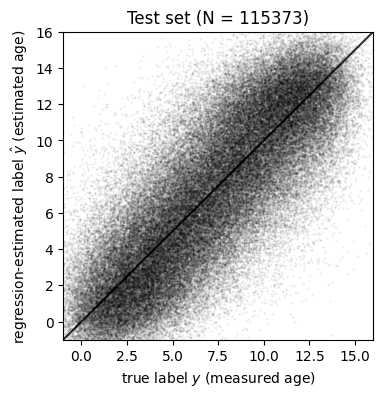

In [50]:
plt.title("Test set (N = {:d})".format(N_test))
plt.scatter(Y_test, Y_test_flat, s=0.2, c="k", alpha=0.1)
foo = plt.ylim()
plt.plot(foo, foo, "k-", alpha=0.8, zorder=-10)
plt.ylim(agelim)
plt.xlim(agelim)
plt.xlabel("true label $y$ (measured age)")
plt.ylabel("regression-estimated label $\hat{y}$ (estimated age)")

Text(0, 0.5, 'MSV-estimated label $\\tilde{y}$ (estimated age)')

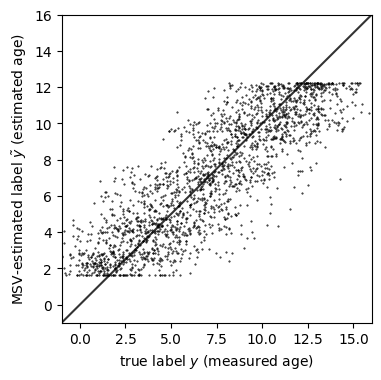

In [80]:
# Perform MSV's suggested replacement for the regression
Y_valid_msv = np.interp(radii_valid, mean_train_radii, mean_train_ages)
plt.scatter(Y_valid, Y_valid_msv, s=0.2, c="k")
plt.plot(agelim, agelim, "k-", alpha=0.8, zorder=-10)
plt.ylim(agelim)
plt.xlim(agelim)
plt.xlabel("true label $y$ (measured age)")
plt.ylabel(r"MSV-estimated label $\tilde{y}$ (estimated age)")